In [246]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
#%run feature_engineering.ipynb

In [247]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [248]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [249]:
# Set the maximum number of columns displayed in DataFrames
pd.set_option('display.max_columns', None)

# Set the display format for floating-point numbers
pd.options.display.float_format = '{:,.2f}'.format

In [250]:
dataset['target'].value_counts()

target
0    326265
1     28925
Name: count, dtype: int64

We will conduct a clustering analysis on the population subset with target=1, representing individuals who churn. Following the algorithm, we'll perform a comprehensive analysis and generate actionable recommendations based on the clustered data.

In [251]:
# Filter the DataFrame to include only rows where the target variable=1
df = dataset[dataset['target'] == 1]
df.shape

(28925, 22)

In [252]:
df.head(2)

,id,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,target,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category
26,146871,0.02,0.11,0.99,"1,049.54",0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.00,1,11,1,1,0.48,0,4,4
27,146872,0.00,0.02,0.00,372.02,0.00,0.98,0.00,0.00,0.00,0.93,0.00,0.00,0.00,1,1,2,1,1.08,0,4,4


In [253]:
df.isnull().sum()

id                               0
amount_rub_clo_prc            2432
amount_rub_sup_prc            2432
rest_dynamic_save_3m             0
rest_avg_cur                     0
amount_rub_nas_prc            2432
amount_rub_atm_prc            2432
rest_dynamic_fdep_3m             0
rest_avg_paym                    0
ldeal_grace_days_pct_med         0
rest_dynamic_cur_3m              0
rest_dynamic_paym_3m             0
rest_dynamic_il_3m               0
rest_dynamic_cc_3m               0
target                           0
pack_encoded                     0
number_products                  0
new_age_category_numeric         0
new_setup_tenor                  0
total_turnover_category          0
total_turnover_1m_category       0
total_turnover_3m_category       0
dtype: int64

In [254]:
# Columns with missing values
cols_with_missing = ['amount_rub_clo_prc', 'amount_rub_sup_prc', 
                     'amount_rub_nas_prc', 'amount_rub_atm_prc']

# Impute missing values with mean
for col in cols_with_missing:
    # Fill missing values with the mean of each column using .loc
    df.loc[:, col] = df[col].fillna(df[col].mean())

In [255]:
df.isnull().sum()

id                            0
amount_rub_clo_prc            0
amount_rub_sup_prc            0
rest_dynamic_save_3m          0
rest_avg_cur                  0
amount_rub_nas_prc            0
amount_rub_atm_prc            0
rest_dynamic_fdep_3m          0
rest_avg_paym                 0
ldeal_grace_days_pct_med      0
rest_dynamic_cur_3m           0
rest_dynamic_paym_3m          0
rest_dynamic_il_3m            0
rest_dynamic_cc_3m            0
target                        0
pack_encoded                  0
number_products               0
new_age_category_numeric      0
new_setup_tenor               0
total_turnover_category       0
total_turnover_1m_category    0
total_turnover_3m_category    0
dtype: int64

### Clustering Algorithm: K-Means

In [256]:
# Drop the target variable column to get feature data
X = df.drop(columns=['target','id'])

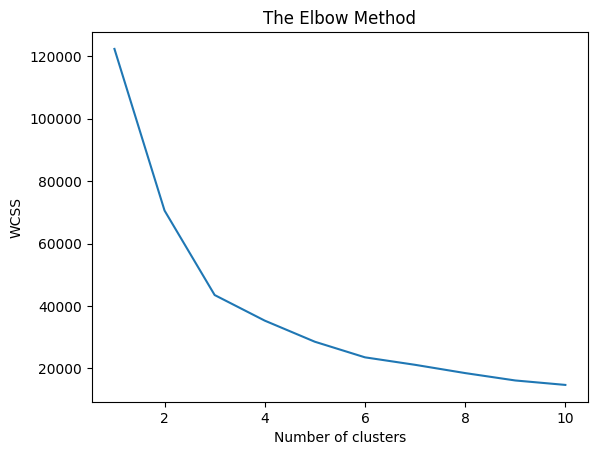

In [257]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('The Elbow Method')
plt.show()

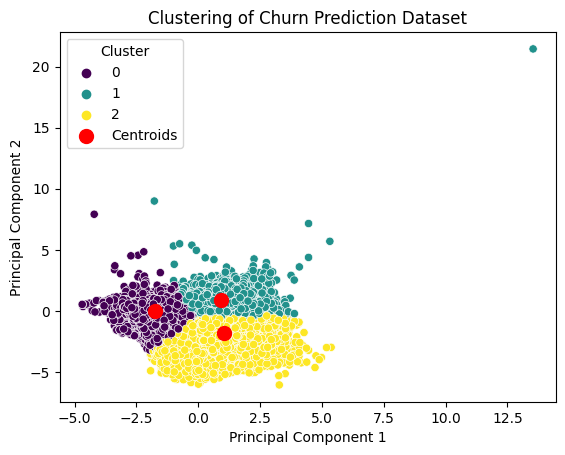

In [258]:
# Choose the number of clusters
k = 3

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Get cluster centers
centroids = kmeans.cluster_centers_

# Add cluster labels to the dataframe
X['Cluster'] = clusters

# Visualize clusters and centroids
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X['Cluster'], palette='viridis', legend='full')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')

plt.title('Clustering of Churn Prediction Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [259]:
X['Cluster'].value_counts()

Cluster
1    12634
0    10234
2     6057
Name: count, dtype: int64

In [260]:
for labels in set(clusters):
    print('\nCluster {}:'.format(labels))
    print('Number of Instances: {}'.format(X[clusters == labels].shape[0]))
    display(X[clusters == labels].describe())


Cluster 0:
Number of Instances: 10234


,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category,Cluster
count,"10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00","10,234.00"
mean,0.01,0.03,0.09,"21,358.52",0.01,0.83,0.02,347.04,0.00,0.85,0.02,0.01,0.00,7.32,0.40,1.07,0.90,0.00,4.05,4.46,0.00
std,0.03,0.06,0.27,"79,558.17",0.03,0.24,0.10,"4,589.88",0.01,0.21,0.11,0.09,0.04,3.66,0.85,0.30,0.84,0.00,1.42,0.85,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,"1,448.48",0.00,0.70,0.00,0.00,0.00,0.71,0.00,0.00,0.00,5.00,0.00,1.00,0.26,0.00,4.00,4.00,0.00
50%,0.00,0.00,0.00,"4,779.21",0.00,0.96,0.00,0.00,0.00,0.99,0.00,0.00,0.00,9.00,0.00,1.00,0.54,0.00,5.00,5.00,0.00
75%,0.01,0.07,0.00,"16,753.40",0.01,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00,1.00,1.00,1.32,0.00,5.00,5.00,0.00
max,0.47,0.64,1.00,"3,463,778.04",0.65,1.00,1.00,"211,603.82",1.00,1.00,1.00,1.00,1.00,11.00,10.00,2.00,4.70,0.00,5.00,5.00,0.00



Cluster 1:
Number of Instances: 12634


,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category,Cluster
count,"12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00","12,634.00"
mean,0.01,0.04,0.06,"21,371.57",0.01,0.81,0.00,"9,630.59",0.00,0.23,0.19,0.00,0.00,4.25,0.52,1.08,1.32,0.00,1.85,1.70,1.00
std,0.03,0.05,0.19,"68,753.67",0.03,0.22,0.02,"47,870.02",0.01,0.23,0.30,0.03,0.04,3.33,0.93,0.28,0.89,0.00,1.57,1.53,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.59,0.00,1.00,0.00,1.00
50%,0.00,0.01,0.00,"3,860.79",0.00,0.89,0.00,0.00,0.00,0.19,0.00,0.00,0.00,4.00,0.00,1.00,1.09,0.00,1.00,1.00,1.00
75%,0.01,0.06,0.00,"18,526.96",0.01,0.99,0.00,"3,961.68",0.00,0.41,0.38,0.00,0.00,5.00,1.00,1.00,1.87,0.00,3.00,3.00,1.00
max,0.38,0.42,1.00,"3,319,340.33",0.39,1.00,0.66,"3,860,107.02",0.50,1.00,1.00,1.00,1.00,11.00,10.00,2.00,5.05,0.00,5.00,5.00,1.00



Cluster 2:
Number of Instances: 6057


,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category,Cluster
count,"6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00","6,057.00"
mean,0.09,0.21,0.07,"8,866.69",0.07,0.22,0.00,"2,083.98",0.01,0.43,0.11,0.01,0.01,4.13,0.86,1.05,1.57,0.00,2.67,2.59,2.00
std,0.17,0.22,0.22,"21,201.51",0.17,0.23,0.02,"9,302.76",0.07,0.32,0.25,0.06,0.10,3.54,1.35,0.25,0.95,0.00,1.66,1.65,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,2.00
25%,0.00,0.04,0.00,729.17,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,1.00,0.00,1.00,0.77,0.00,1.00,1.00,2.00
50%,0.02,0.16,0.00,"2,860.18",0.00,0.16,0.00,0.00,0.00,0.43,0.00,0.00,0.00,4.00,0.00,1.00,1.43,0.00,3.00,3.00,2.00
75%,0.11,0.31,0.00,"8,209.98",0.04,0.39,0.00,0.00,0.00,0.65,0.00,0.00,0.00,5.00,1.00,1.00,2.24,0.00,4.00,4.00,2.00
max,1.00,1.00,1.00,"412,388.17",1.00,1.00,0.69,"313,085.67",1.00,1.00,1.00,1.00,1.00,11.00,16.00,2.00,5.16,0.00,5.00,5.00,2.00


#### Recomendations Cluster 0

Cluster 0:
Number of Instances: 10,234
-  This cluster has relatively low average values across most features.
-  Customers in this cluster have an average current balance of approximately 21,358.52 RUB and an average salary account balance of 347.04 RUB.
-  They tend to have a moderate number of products.
-  The average age category seems to be around 1 (20-55 years).
-  Average tenure of customers in this cluster seems to be around 4 months.0
-  They have a moderate to high fraction of transactions with MCC to the whole amount of the transaction in various categories.

**Recommendations:**
-  Implement targeted marketing campaigns to promote additional products or services to increase the number of products per customer.
-  Provide personalized offers or discounts to incentivize customers to maintain higher balances in their accounts.
-  Offer financial planning services or incentives to encourage long-term engagement and loyalty.

#### Recomendations Cluster 1

Cluster 1:
Number of Instances: 12,634
-  This cluster has relatively higher average values for rest_avg_paym and rest_avg_cur compared to other clusters.
-  Customers in this cluster have a higher average salary account balance (rest_avg_paym) of approximately 9,630.59 RUB and a higher average current balance (rest_avg_cur) of 21,371.57 RUB.
-  They tend to have a moderate number of products.
-  The average age category is similar to Cluster 0, around 1 (20-55 years).
-  Average tenure of customers in this cluster seems to be around 1 month.

**Recommendations:**
-  Focus on retaining existing customers by offering personalized services or rewards tailored to their spending habits.
-  Provide financial management tools or educational resources to help customers optimize their account balances and transactions.
-  Monitor customer activity closely to detect early signs of potential churn and intervene proactively with targeted retention strategies.

#### Recomendations Cluster 2

Cluster 2: Number of Instances: 6,057
-  This cluster has relatively higher average values for amount_rub_clo_prc and amount_rub_sup_prc compared to other clusters.
-  Customers in this cluster have a higher fraction of transactions with MCC to the whole amount of the transaction in various categories.
-  They have a lower average current balance compared to Clusters 0 and 1.
-  The average age category is also around 1 (20-55 years).
-  Average tenure of customers in this cluster seems to be around 2 months.

**Recommendations:**
-  Focus on understanding the spending patterns and preferences of customers in this cluster to offer relevant products or services.
-  Provide incentives or rewards for increasing account balances or using specific banking products.
-  Offer personalized financial advice or assistance to help customers manage their transactions more effectively and improve their financial health.